"""
算法实现思路：
1.从数据集中随机选取k个样本作为初始簇中心，即质心
2.计算每个数据点到每一个簇中心的距离，将其归入距离最小的那个簇中
3.遍历完一遍数据集后，将形成k个簇，计算每个簇的数据点的均值作为簇中心
4.循环执行2、3直到簇中心不在发生变化时停止（也可以定义迭代次数作为终止条件，不过本次没有实现）
"""

In [1]:
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.cluster import Birch
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
#定义方法求数据点和选择的质心之间的距离
def getDistance(data, centroid):
    assert len(data) == len(centroid)
    d = 0
    for i in range(len(data)):
        d += (data[i] - centroid[i]) ** 2
    return d**0.5

#定义方法随机选择质心
def getinitCentroids(dataset, k):
    centroids = []
    centroids_index = []
    for i in range(k):
        index = np.random.randint(0, len(dataset))
        while index in centroids_index:
            index = np.random.randint(0, len(dataset))
        centroids_index.append(index)
        centroids.append(dataset[index])
    return np.array(centroids)

def myKmeans(dataset, k):
    numSamples, numFeatures = dataset.shape
    #定义一个二维数组，第一列保存所属簇的类别，第二列保存离质心的距离
    clusterData = np.array(np.zeros((numSamples, 2)))
    clusterChanged = True
    centroids = getinitCentroids(dataset, k)
    while clusterChanged:
        clusterChanged = False
        #遍历每一个数据
        for i in range(numSamples):
            minDist = 100000.0              #初始化样本到质心的最小距离
            clusterIndex = 0                #初始化样本所属簇的类别
            #遍历每一个质心
            for j in range(k):
                distance = getDistance(dataset[i], centroids[j])
                if distance < minDist:
                    minDist = distance
                    clusterData[i, 1] = minDist
                    clusterIndex = j
            if clusterData[i, 0] != clusterIndex:
                clusterChanged = True
                clusterData[i, 0] = clusterIndex
        for a in range(k):
            #获得第a个簇中的所有数据点的行索引
            cluster_index = np.nonzero(clusterData[:, 0] == a)
            #根据索引获得该簇中的数据
            OneCluster = dataset[cluster_index]
            #计算新的质心
            centroids[a, :] = np.mean(OneCluster, axis=0)
    return centroids, clusterData

In [3]:
#定义方法计算聚类的纯度
def getPurity(labels, clusterData, k):
    cluster_maxlabels = []
    for i in range(k):
        #获得第i个簇中的所有数据点的行索引
        cluster_index = np.nonzero(clusterData[:,0] == i)
        #根据索引获得该簇中的类别标签
        labelsCluster = labels[cluster_index]
        label = max(Counter(labelsCluster).values())
        cluster_maxlabels.append(label)
    purity = sum(cluster_maxlabels)/len(labels)
    return purity

In [4]:
#定义方法求RI
"""
兰德系数RI = (TP + TN) / (TP + FP + TN + FN)
TP: 同类同簇
FP: 同簇不同类
FN: 同类不同簇
TN: 不同簇不同类
"""
def getRI(labels, clusterData, k):
    TP = 0          #同一簇中任取两个样本属于同一类
    TP_FP = 0       #同一簇中任取两个样本点的情况
    TP_FN = 0       #任意两个同类样本点分布在同一簇和不同簇的所有情况
    TP_FP_TN_FN = (len(labels)*(len(labels)-1))/2   #所有样本点中任取两个样本点的所有情况
    for a in list(Counter(labels).values()):
        TP_FN += (a*(a-1))/2
    for i in range(k):
        #获得第i个簇中的所有数据点的行索引
        cluster_index = np.nonzero(clusterData[:,0] == i)
        #根据索引获得该簇中的类别标签
        labelsCluster = labels[cluster_index]
        labelsDict = Counter(labelsCluster)
        labelsCount = list(labelsDict.values())
        TP_FP += (len(labelsCluster)*(len(labelsCluster)-1))/2
        for j in labelsCount:
            if j >1:
                TP += (j*(j-1))/2
    FP = TP_FP - TP
    FN = TP_FN - TP
    TP_TN = TP_FP_TN_FN - FP - FN
    RI = TP_TN / TP_FP_TN_FN
    return RI

In [5]:
#定义方法获得一个clusterData,便于使用上面的方法计算其模型的Purity和RI
"""
由于此时只需用到二维数组的形式并使其第一列存储数据所属簇索引，不需要第二列数据，
所以使其默认为0即可
"""
def getclusterData(cluster_predict):
    clusterData = np.array(np.zeros((len(cluster_predict), 2)))
    for i in range(len(cluster_predict)):
        clusterData[i,0] = cluster_predict[i]
    return clusterData

In [6]:
gmm = GaussianMixture(n_components=3)

In [7]:
bir = Birch()

## 鸢尾花数据集

In [8]:
D1 = pd.read_csv("D1.data",header=None)

k1 = 3
dataset1 = D1.iloc[:,0:4].values
labels1 = D1.iloc[:, -1].values
centroids1, clusterData1 = myKmeans(dataset1, k1)

D1_Kmeans_purity = getPurity(labels1, clusterData1, k1)
D1_Kmeans_RI = getRI(labels1, clusterData1, k1)

print("K-Means模型在鸢尾花数据集上的纯度为：", D1_Kmeans_purity)
print("K-Means模型在鸢尾花数据集上的兰德系数为：", D1_Kmeans_RI)

K-Means模型在鸢尾花数据集上的纯度为： 0.8933333333333333
K-Means模型在鸢尾花数据集上的兰德系数为： 0.8797315436241611


In [9]:
gmm.fit(dataset1)
cluster_predict_D1_gmm = gmm.predict(dataset1)
clusterData1_gmm = getclusterData(cluster_predict_D1_gmm)

D1_gmm_purity = getPurity(labels1, clusterData1_gmm, k1)
D1_gmm_RI = getRI(labels1, clusterData1_gmm, k1)

print("高斯混合模型在鸢尾花数据集上的纯度为：", D1_gmm_purity)
print("高斯混合模型模型在鸢尾花数据集上的兰德系数为：", D1_gmm_RI)

高斯混合模型在鸢尾花数据集上的纯度为： 0.9666666666666667
高斯混合模型模型在鸢尾花数据集上的兰德系数为： 0.9574944071588367


In [10]:
bir.fit(dataset1)
cluster_predict_D1_bir = bir.predict(dataset1)
clusterData1_bir = getclusterData(cluster_predict_D1_bir)

D1_bir_purity = getPurity(labels1, clusterData1_bir, k1)
D1_bir_RI = getRI(labels1, clusterData1_bir, k1)

print("Birch模型在鸢尾花数据集上的纯度为：", D1_bir_purity)
print("Birch模型模型在鸢尾花数据集上的兰德系数为：", D1_bir_RI)

Birch模型在鸢尾花数据集上的纯度为： 0.8133333333333334
Birch模型模型在鸢尾花数据集上的兰德系数为： 0.8195973154362416


## 乳腺癌数据集

In [11]:
D2 = pd.read_csv("D2.data", header=None)

k2 = 3
dataset2 = D2.iloc[:, 2::].values
labels2 = D2.iloc[:, 1].values
centroids2, clusterData2 = myKmeans(dataset2, k2)

D2_Kmeans_purity = getPurity(labels2, clusterData2, k2)
D2_Kmeans_RI = getRI(labels2, clusterData2, k2)

print("K-Means模型在乳腺癌数据集上的纯度为：", D2_Kmeans_purity)
print("K-Means模型在乳腺癌数据集上的兰德系数为：", D2_Kmeans_RI)

K-Means模型在乳腺癌数据集上的纯度为： 0.8875219683655536
K-Means模型在乳腺癌数据集上的兰德系数为： 0.7667268991806728


In [12]:
gmm.fit(dataset2)
cluster_predict_D2_gmm = gmm.predict(dataset2)
clusterData2_gmm = getclusterData(cluster_predict_D2_gmm)

D2_gmm_purity = getPurity(labels2, clusterData2_gmm, k2)
D2_gmm_RI = getRI(labels2, clusterData2_gmm, k2)

print("高斯混合模型在乳腺癌数据集上的纯度为：", D2_gmm_purity)
print("高斯混合模型模型在乳腺癌数据集上的兰德系数为：", D2_gmm_RI)

高斯混合模型在乳腺癌数据集上的纯度为： 0.9349736379613357
高斯混合模型模型在乳腺癌数据集上的兰德系数为： 0.8598480160400009


In [13]:
bir.fit(dataset2)
cluster_predict_D2_bir = bir.predict(dataset2)
clusterData2_bir = getclusterData(cluster_predict_D2_bir)

D2_bir_purity = getPurity(labels2, clusterData2_bir, k2)
D2_bir_RI = getRI(labels2, clusterData2_bir, k2)

print("Birch模型在乳腺癌数据集上的纯度为：", D2_bir_purity)
print("Birch模型模型在乳腺癌数据集上的兰德系数为：", D2_bir_RI)

Birch模型在乳腺癌数据集上的纯度为： 0.8189806678383128
Birch模型模型在乳腺癌数据集上的兰德系数为： 0.6907349191811678


## 鲍鱼年龄预测数据集（使用的是第二次作业中经过处理后的数据集）

In [14]:
D3 = pd.read_csv("D3.csv", header=None)

k3 = 3
dataset3 = D3.iloc[:, 1:-1].values
labels3 = D3.iloc[:, -1].values
centroids3, clusterData3 = myKmeans(dataset3, k3)

D3_Kmeans_purity = getPurity(labels3, clusterData3, k3)
D3_Kmeans_RI = getRI(labels3, clusterData3, k3)

print("K-Means模型在鲍鱼年龄预测数据集上的纯度为：", D3_Kmeans_purity)
print("K-Means模型在鲍鱼年龄预测数据集上的兰德系数为：", D3_Kmeans_RI)

K-Means模型在鲍鱼年龄预测数据集上的纯度为： 0.7766339478094326
K-Means模型在鲍鱼年龄预测数据集上的兰德系数为： 0.5161716185239915


In [15]:
gmm.fit(dataset3)
cluster_predict_D3_gmm = gmm.predict(dataset3)
clusterData3_gmm = getclusterData(cluster_predict_D3_gmm)

D3_gmm_purity = getPurity(labels3, clusterData3_gmm, k3)
D3_gmm_RI = getRI(labels3, clusterData3_gmm, k3)

print("高斯混合模型在鲍鱼年龄预测数据集上的纯度为：", D3_gmm_purity)
print("高斯混合模型模型在鲍鱼年龄预测数据集上的兰德系数为：", D3_gmm_RI)

高斯混合模型在鲍鱼年龄预测数据集上的纯度为： 0.8125448886760833
高斯混合模型模型在鲍鱼年龄预测数据集上的兰德系数为： 0.576241954435758


In [16]:
bir.fit(dataset3)
cluster_predict_D3_bir = bir.predict(dataset3)
clusterData3_bir = getclusterData(cluster_predict_D3_bir)

D3_bir_purity = getPurity(labels3, clusterData3_bir, k3)
D3_bir_RI = getRI(labels3, clusterData3_bir, k3)

print("Birch模型在鲍鱼年龄预测数据集上的纯度为：", D3_bir_purity)
print("Birch模型模型在鲍鱼年龄预测数据集上的兰德系数为：", D3_bir_RI)

Birch模型在鲍鱼年龄预测数据集上的纯度为： 0.7785491979889874
Birch模型模型在鲍鱼年龄预测数据集上的兰德系数为： 0.524131189133707


## 结果可视化

In [17]:
import matplotlib.pyplot as plt

In [23]:
x = np.arange(2)
bar_width = 0.3
tick_label = ["Purity", "RI"]

In [20]:
y_D1_KMeans = [D1_Kmeans_purity, D1_Kmeans_RI]
y_D1_gmm = [D1_gmm_purity, D1_gmm_RI]
y_D1_bir = [D1_bir_purity, D1_bir_RI]

In [21]:
y_D2_KMeans = [D2_Kmeans_purity, D2_Kmeans_RI]
y_D2_gmm = [D2_gmm_purity, D2_gmm_RI]
y_D2_bir = [D2_bir_purity, D2_bir_RI]

In [22]:
y_D3_KMeans = [D3_Kmeans_purity, D3_Kmeans_RI]
y_D3_gmm = [D3_gmm_purity, D3_gmm_RI]
y_D3_bir = [D3_bir_purity, D3_bir_RI]

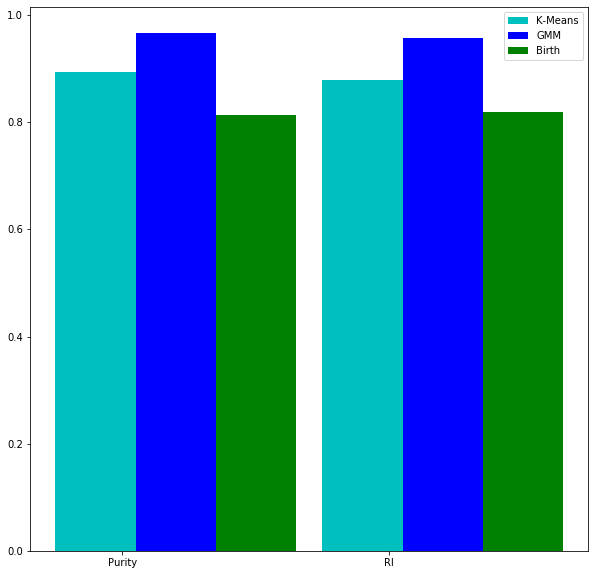

In [27]:
plt.figure(figsize=(10, 10))
plt.bar(x, y_D1_KMeans, bar_width, align="center", color="c", label="K-Means")
plt.bar(x+bar_width, y_D1_gmm, bar_width, align="center", color="b", label="GMM")
plt.bar(x+bar_width+bar_width, y_D1_bir, bar_width, align="center", color="g", label="Birth")
plt.xticks(x+bar_width/3, tick_label)
plt.legend()
plt.savefig('./D1.svg')
plt.show()

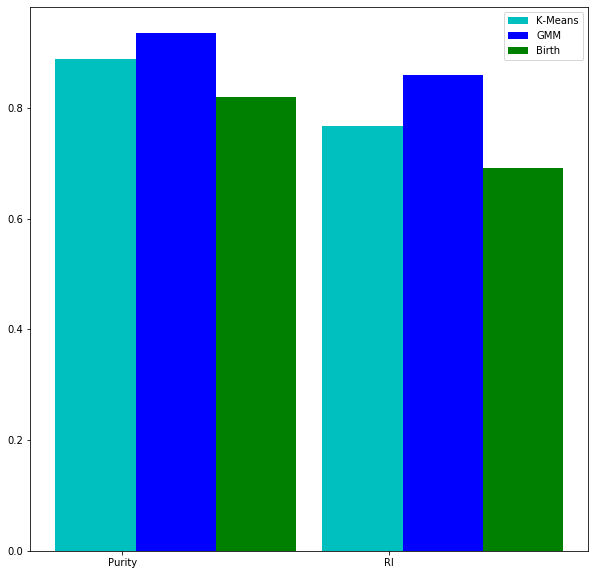

In [28]:
plt.figure(figsize=(10, 10))
plt.bar(x, y_D2_KMeans, bar_width, align="center", color="c", label="K-Means")
plt.bar(x+bar_width, y_D2_gmm, bar_width, align="center", color="b", label="GMM")
plt.bar(x+bar_width+bar_width, y_D2_bir, bar_width, align="center", color="g", label="Birth")
plt.xticks(x+bar_width/3, tick_label)
plt.legend()
plt.savefig('./D2.svg')
plt.show()

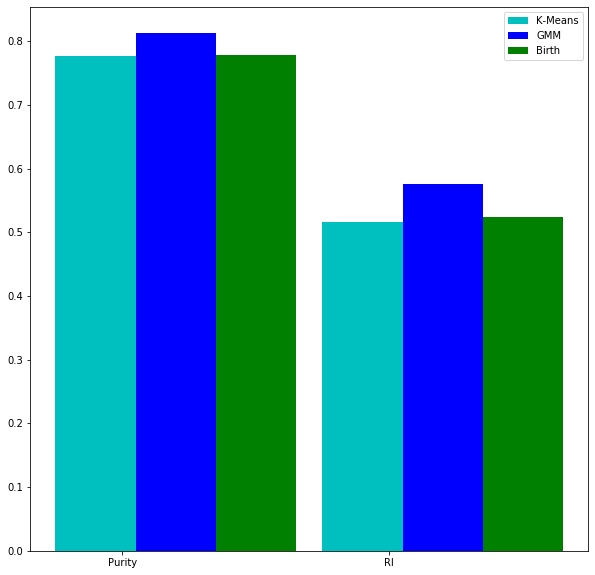

In [29]:
plt.figure(figsize=(10, 10))
plt.bar(x, y_D3_KMeans, bar_width, align="center", color="c", label="K-Means")
plt.bar(x+bar_width, y_D3_gmm, bar_width, align="center", color="b", label="GMM")
plt.bar(x+bar_width+bar_width, y_D3_bir, bar_width, align="center", color="g", label="Birth")
plt.xticks(x+bar_width/3, tick_label)
plt.legend()
plt.savefig('./D3.svg')
plt.show()